In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras import layers, models

# Constants
DATA_DIR = './'
IMAGE_SIZE = (48, 48)
MIN_IDENTITY_ROWS = 29
NUM_SELECTED_IDENTITIES = 130

In [2]:
# Function to load and preprocess images
def load_and_preprocess_images(data_dir, selected_identities):
    image_data = []
    for identity in selected_identities:
        filename = identity
        image_path = os.path.join(data_dir, 'Img/img_align_celeba', filename)
        try:
            img = cv2.imread(image_path)
            if img is None:
                raise Exception(f"Failed to read image: {image_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)
            img = img / 255.0
            image_data.append(img)
        except Exception as e:
            print(f"Error processing image: {image_path}")
            print(str(e))
    return np.array(image_data)

# Function to split data
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def evaluate_models(models, X_train, y_train):
    results = []
    names = []
    for name, model in models:
        if isinstance(model, tf.keras.models.Sequential):  # Check if the model is a CNN
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(X_train, y_train, epochs=5, verbose=0)  # Training the CNN model
            cv_results = history.history['accuracy'][-1]  # Get the final accuracy
        else:
            kfold = KFold(n_splits=10, random_state=7, shuffle=True)
            cv_results = cross_val_score(model, X_train.reshape(len(X_train), -1), y_train, cv=kfold, scoring='accuracy').mean()
        
        results.append(cv_results)
        names.append(name)
        msg = f"{name}: {cv_results}"
        print(msg)
        
# Calculate HSV histograms for a sample image
def calculate_hsv_histograms(sample_image):
    # Convert the image data type to uint8 (8-bit)
    sample_image = (sample_image * 255).astype(np.uint8)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HSV)

    # Split the image into its color channels
    hue_channel = hsv_image[:, :, 0]
    saturation_channel = hsv_image[:, :, 1]
    value_channel = hsv_image[:, :, 2]

    # Define the number of bins for the histogram
    num_bins = 256

    # Create histograms for each color channel
    hist_hue, bin_edges_hue = np.histogram(hue_channel, bins=num_bins, range=(0, 256))
    hist_saturation, bin_edges_saturation = np.histogram(saturation_channel, bins=num_bins, range=(0, 256))
    hist_value, bin_edges_value = np.histogram(value_channel, bins=num_bins, range=(0, 256))

    return hist_hue, bin_edges_hue, hist_saturation, bin_edges_saturation, hist_value, bin_edges_value

     
def plot_hsv_histogram(hist_hue, bin_edges_hue, hist_saturation, bin_edges_saturation, hist_value, bin_edges_value):
    # Plot the histograms
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.plot(bin_edges_hue[0:-1], hist_hue, color='r')
    plt.title('Hue Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(132)
    plt.plot(bin_edges_saturation[0:-1], hist_saturation, color='g')
    plt.title('Saturation Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(133)
    plt.plot(bin_edges_value[0:-1], hist_value, color='b')
    plt.title('Value Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [3]:
## Load Data

# Load identities data
ident_filename = os.path.join(DATA_DIR, 'Anno/identity_CelebA.txt')
ident_data = pd.read_csv(ident_filename, delim_whitespace=True, skiprows=1, names=["image_id", "identity_id"])

# Select identities
identity_counts = ident_data['identity_id'].value_counts()
selected_identities = identity_counts[identity_counts > MIN_IDENTITY_ROWS].index.tolist()
selected_identities = np.random.choice(selected_identities, NUM_SELECTED_IDENTITIES, replace=False)
filtered_data = ident_data[ident_data['identity_id'].isin(selected_identities)]

# Load and preprocess images
image_data = load_and_preprocess_images(DATA_DIR, filtered_data['image_id'])

# Convert the image data list to a NumPy array
X = np.array(image_data)
y = filtered_data['identity_id']  


X Shape: (3907, 48, 48, 3)
y Shape: (3907,)
Numbers of samples: 3907
Numbers of features: 48
Numbers of classes: 130


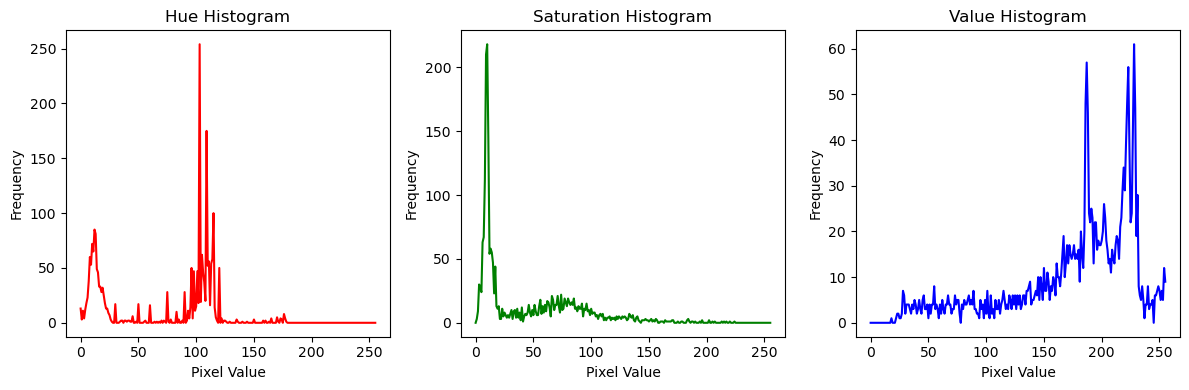

In [4]:
## Exploratory Data Analysis
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

n_samples = X.shape[0]
n_features = X.shape[1]
n_classes = y.unique().shape[0]

print(f'Numbers of samples: {n_samples}')
print(f'Numbers of features: {n_features}')
print(f'Numbers of classes: {n_classes}')

# Select a sample image for histogram visualization (you can change the index)
sample_image = X[0]

# Calculate HSV histograms for the sample image
hist_hue, bin_edges_hue, hist_saturation, bin_edges_saturation, hist_value, bin_edges_value = calculate_hsv_histograms(sample_image)
plot_hsv_histogram(hist_hue, bin_edges_hue, hist_saturation, bin_edges_saturation, hist_value, bin_edges_value)


Identity Counts:
3782    35
9152    32
1854    30
4874    30
4462    30
        ..
9288    30
6314    30
7427    30
8940    30
6172    30
Name: identity_id, Length: 130, dtype: int64


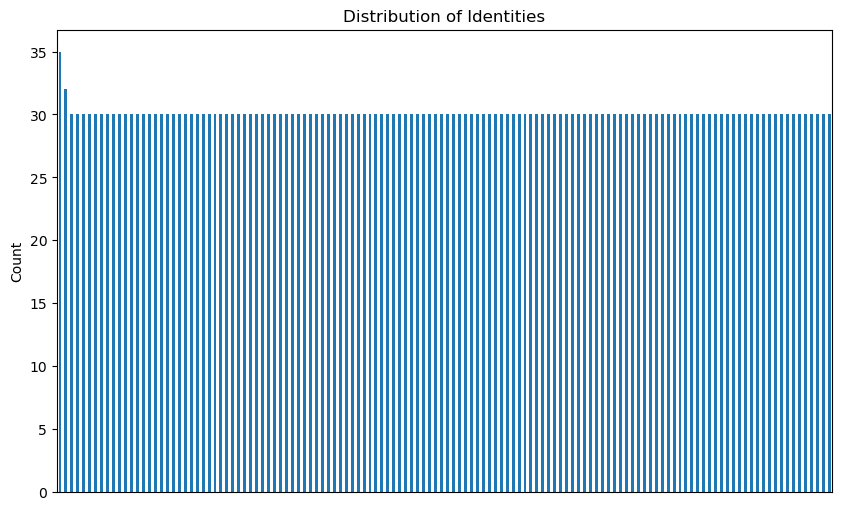

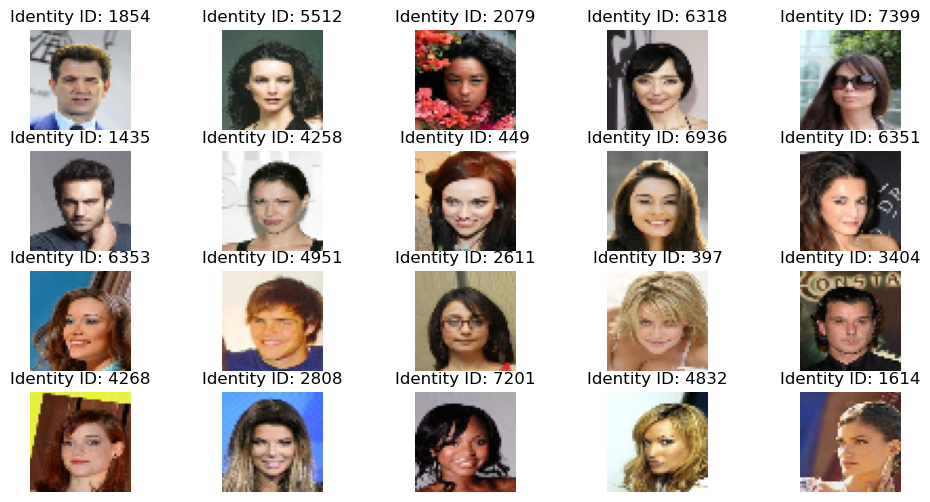

In [5]:
# Count the number of samples per identity
identity_counts = filtered_data['identity_id'].value_counts()
print("Identity Counts:")
print(identity_counts)

# Visualize the distribution of identities
plt.figure(figsize=(10, 6))
identity_counts.plot(kind='bar')
plt.title('Distribution of Identities')
plt.ylabel('Count')
plt.xticks([])
plt.show()

# Display sample images
plt.figure(figsize=(12, 6))
for i in range(20):  # Display the first 6 images as samples
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_data[i])
    plt.title(f"Identity ID: {filtered_data['identity_id'].iloc[i]}")
    plt.axis('off')
plt.show()

In [6]:
# Split data
X = image_data
y = filtered_data['identity_id']
X_train, X_test, y_train, y_test = split_data(X, y)

In [7]:
# Map your original labels to class indices [0, 29]
label_mapping = {}  # Create a mapping from original labels to class indices
for idx, identity_id in enumerate(selected_identities):
    label_mapping[identity_id] = idx

# Use the mapping to remap your labels
y_train_mapped = np.array([label_mapping[label] for label in y_train])

In [8]:
# Define models
models = [
    ('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
    ('LDA', LinearDiscriminantAnalysis()),
    #('KNN', KNeighborsClassifier()),
    #('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('CNN', models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_SELECTED_IDENTITIES, activation='softmax')
    ]))
]

# Evaluate models
evaluate_models(models, X_train, y_train_mapped)

LR: 0.36702916359465887
LDA: 0.2505539854182027
NB: 0.1375942082411731
SVM: 0.1452803719177521
CNN: 0.7843199968338013


In [32]:
# Initialize and train the SVM model
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train.reshape(len(X_train), -1), y_train)

# Make predictions on test data
X_test_flattened = X_test.reshape(len(X_test), -1)
y_pred = svm_classifier.predict(X_test_flattened)

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          79       0.25      0.29      0.27         7
          90       0.00      0.00      0.00         3
         183       0.00      0.00      0.00         3
         199       0.00      0.00      0.00         6
         342       1.00      0.17      0.29         6
         368       0.33      0.20      0.25         5
         384       0.00      0.00      0.00         4
         404       0.17      0.25      0.20         4
         405       1.00      0.33      0.50         6
         458       0.33      0.25      0.29         8
         616       0.00      0.00      0.00         1
         621       0.00      0.00      0.00         7
         675       0.50      0.25      0.33         8
         708       0.29      1.00      0.44         2
         778       1.00      0.20      0.33         5
         824       1.00      1.00      1.00         2
         871       0.17      0.25      0.20         4
         901       0.27    

/Users/mattcutler/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattcutler/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattcutler/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattcutler/ana

In [ ]:
lda_classifier = LinearDiscriminantAnalysis()
lda.classifier.fit(X_train.reshape(len(X_train), -1), y_train)

# Make predictions on test data
X_test_flattened = X_test.reshape(len(X_test), -1)
y_pred = svm_classifier.predict(X_test_flattened)

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Train the CNN model
cnn_model = models[-1][1]  # Get the CNN model from the last entry in the models array
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')